# Importing Data

We first define some utitlity functions to manipulate our datasets.

In [1]:
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

/Users/filipporonzino/anaconda3/envs/envallen/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def initialize_cache(data_dir):
    """
    Initialize the AllenSDK EcephysProjectCache object for the given data directory.
    """
    manifest_path = os.path.join(data_dir, "manifest.json")
    return EcephysProjectCache.from_warehouse(manifest=manifest_path)

In [ ]:
def get_session_data_from_sessionid(session_id, cache):
    """
    Get the EcephysSession object for the given session ID."
    """
    return cache.get_session_data(session_id)

In [ ]:
def stimulus_spike_table(stimuli_table, columns, session, units):
    """
    Create a table of spike rates for each stimulus presentation and unit.
    """
    stimuli_ids = stimuli_table.index
    print(f"Stimuli IDs: {stimuli_ids}")
    spikes_per_stimulus = session.presentationwise_spike_times(stimulus_presentation_ids = stimuli_ids)
    spikes_per_stimulus.reset_index(inplace=True)
    
    spike_counts = spikes_per_stimulus.groupby(['stimulus_presentation_id', 'unit_id'])['spike_time'].count().reset_index()
    spike_counts.rename(columns={'spike_time': 'spike_count'}, inplace=True)
    
    dataset = pd.merge(spike_counts, stimuli_table[columns + ['duration']], on='stimulus_presentation_id')
    dataset['spikes_per_second'] = dataset['spike_count'] / dataset['duration']
    dataset = dataset.drop(columns=['duration', 'spike_count'])
    dataset['area'] = units.loc[dataset['unit_id'], 'ecephys_structure_acronym'].values

    return dataset

In [5]:
def replace_not_recognized_nulls(dataset, drop_nan = False):
    """
    Replace all values that are not recognized with np.nan.
    Prints the number of replacements if any are found.
    """
    unrecognized_values = ['null', 'NULL', '', ' ']
    
    mask = dataset.isin(unrecognized_values)
    count = mask.sum().sum()  
    
    if count > 0:
        print(f"Replacing {count} unrecognized values with np.nan.")
    
    dataset = dataset.replace(unrecognized_values, np.nan)
    
    if drop_nan:
        dataset = dataset.dropna()
        print("Dropped rows containing NaN values.")

    return dataset

In [6]:
def count_units_by_area(all_areas, session_table, cache):
    """
    Returns a dictionary where the keys are session IDs, and the values are dictionaries of 
    brain areas with their respective unit counts for each session.
    """
    session_area_unit_counts = {}
    units = cache.get_units()
    
    for sid in session_table.index.values:
        session_counts = {}
        
        for area in all_areas:
            maskunits = (units["ecephys_session_id"] == sid) & (units["ecephys_structure_acronym"] == area)
            units_in_area = len(units[maskunits])
            
            session_counts[area] = units_in_area
        
        session_area_unit_counts[sid] = session_counts
    
    return session_area_unit_counts

In [7]:
def get_areas_from_session(session_id, cache):
    """
    Get a list of all brain areas with units in the given session.
    """
    units = cache.get_units()
    areas = units[units['ecephys_session_id'] == session_id]['ecephys_structure_acronym'].unique()
    return areas

In [8]:
def get_all_areas(cache):
    """
    Get a set (unique elements) of all brain areas with units in the dataset.
    """
    all_areas = set()
    for sid in cache.get_session_table().index.values:
        areas = get_areas_from_session(sid, cache)  
        all_areas.update(areas)
    return all_areas

In [9]:
def filter_sessions_by_numerical_column(session_table, column, min_value = 0, max_value = np.inf):
    """
    Filter the session table by a numerical column.
    """
    mask = (session_table[column] >= min_value) & (session_table[column] <= max_value)
    print(f"Filtered out {len(session_table) - mask.sum()} sessions.")
    return session_table[mask]

In [48]:
def compute_entropy(row):
    """
    Compute the entropy  H = -sum(p * log2(p)) of a distribution for a session.
    """
    counts = row.values

    total = counts.sum()
    
    probabilities = counts / total
    probabilities = probabilities[probabilities > 0]
    
    return -np.sum(probabilities * np.log2(probabilities))

## Sessions Analysis

Let us inspect some of the sessions in the dataset, trying to understand the count of the units we have per session.

In [77]:
data_dir = "./allendata"
cache = initialize_cache(data_dir)
session_table = cache.get_session_table()
session_table

,published_at,specimen_id,session_type,age_in_days,sex,full_genotype,unit_count,channel_count,probe_count,ecephys_structure_acronyms
id,,,,,,,,,,
715093703,2019-10-03T00:00:00Z,699733581,brain_observatory_1.1,118.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,884,2219,6,"[CA1, VISrl, nan, PO, LP, LGd, CA3, DG, VISl, ..."
719161530,2019-10-03T00:00:00Z,703279284,brain_observatory_1.1,122.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,755,2214,6,"[TH, Eth, APN, POL, LP, DG, CA1, VISpm, nan, N..."
721123822,2019-10-03T00:00:00Z,707296982,brain_observatory_1.1,125.0,M,Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,444,2229,6,"[MB, SCig, PPT, NOT, DG, CA1, VISam, nan, LP, ..."
732592105,2019-10-03T00:00:00Z,717038288,brain_observatory_1.1,100.0,M,wt/wt,824,1847,5,"[grey, VISpm, nan, VISp, VISl, VISal, VISrl]"
737581020,2019-10-03T00:00:00Z,718643567,brain_observatory_1.1,108.0,M,wt/wt,568,2218,6,"[grey, VISmma, nan, VISpm, VISp, VISl, VISrl]"
739448407,2019-10-03T00:00:00Z,716813543,brain_observatory_1.1,112.0,M,wt/wt,625,2221,6,"[grey, VISam, nan, VIS, VISp, VISl, VISrl]"
742951821,2019-10-03T00:00:00Z,723627604,brain_observatory_1.1,120.0,M,wt/wt,893,2219,6,"[VISal, nan, grey, VISl, VISrl, VISp, VISpm, VIS]"
743475441,2019-10-03T00:00:00Z,722882755,brain_observatory_1.1,121.0,M,wt/wt,553,2225,6,"[LP, LGd, HPF, DG, CA3, CA1, VISrl, nan, PP, P..."
744228101,2019-10-03T00:00:00Z,719817805,brain_observatory_1.1,122.0,M,wt/wt,659,2226,6,"[Eth, TH, LP, POL, APN, DG, CA1, VIS, nan, CA3..."


In [78]:
print("Number of sessions:", len(session_table))

Number of sessions: 58


In [79]:
session_table = session_table[session_table['session_type'] == 'brain_observatory_1.1']
print("Number of sessions after filtering by session type:", len(session_table))

Number of sessions after filtering by session type: 32


Let's check the count for unit and probe in each session.
TODO add explanation

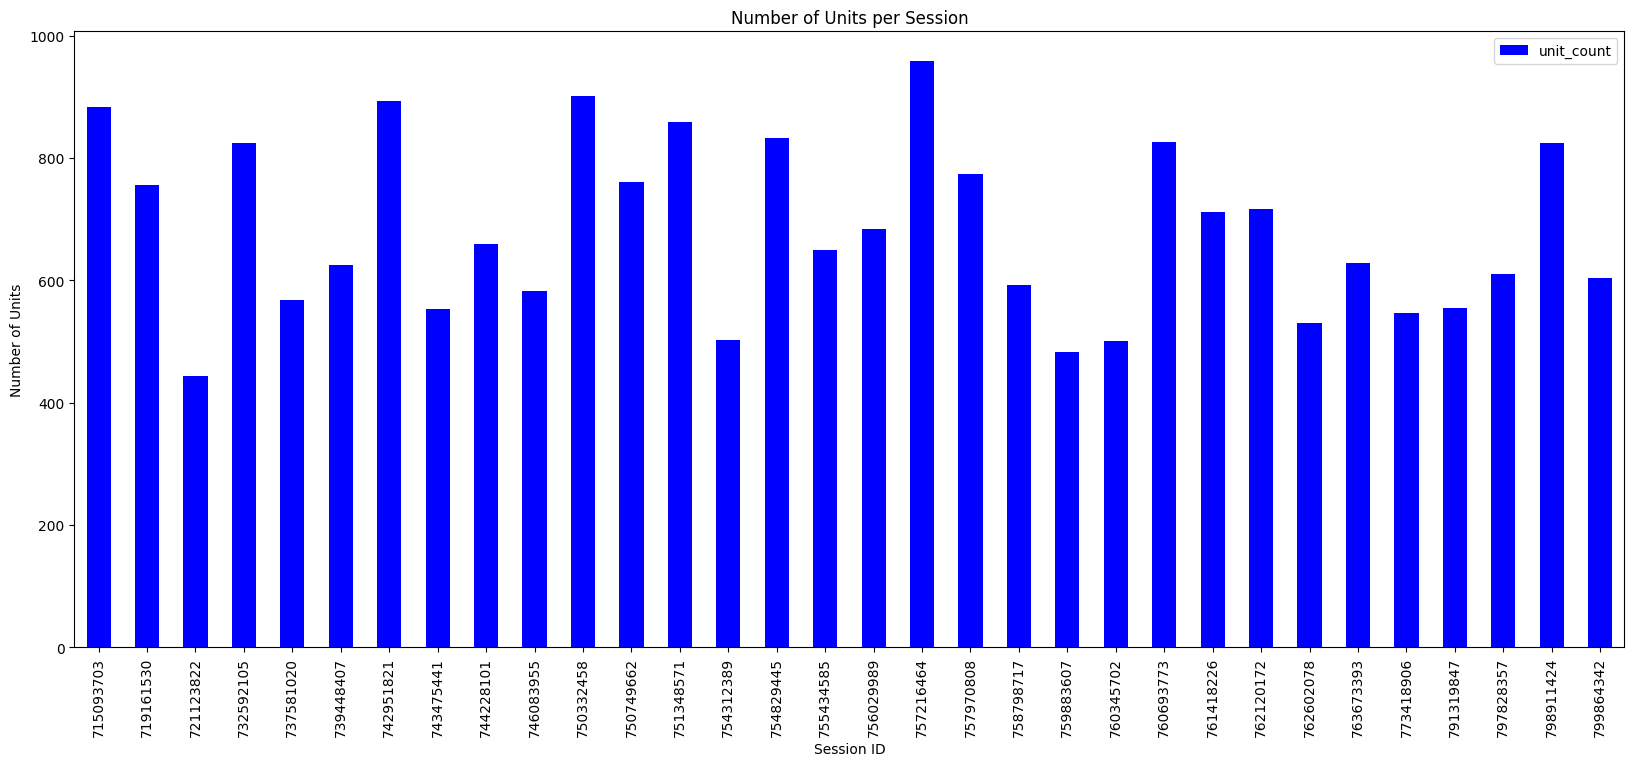

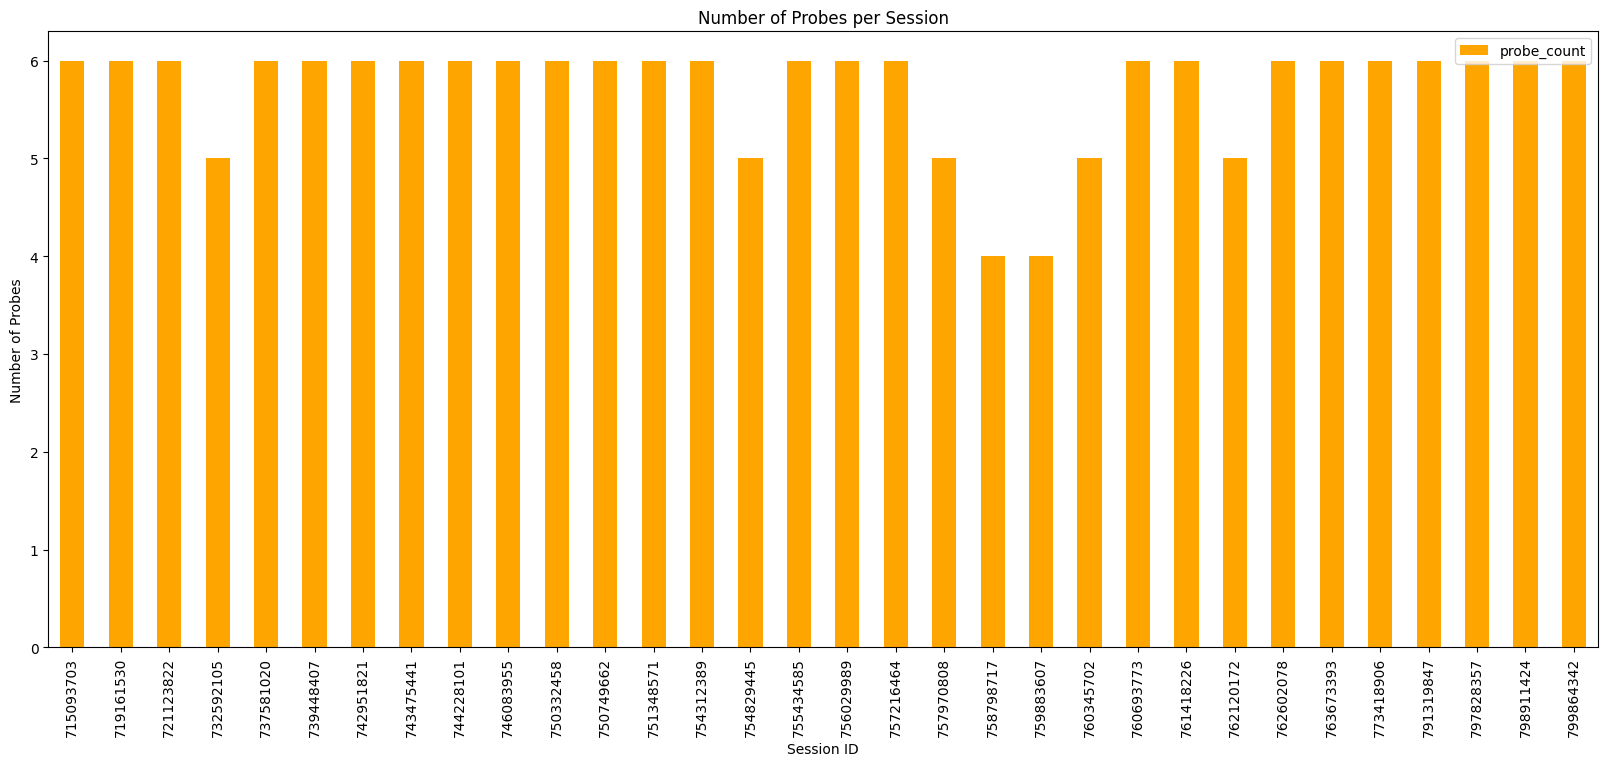

In [80]:
session_table.plot(kind='bar', y='unit_count', figsize=(20, 8), color='blue')
plt.xlabel('Session ID')
plt.ylabel('Number of Units')
plt.title('Number of Units per Session')
plt.show()

session_table.plot(kind='bar', y='probe_count', figsize=(20, 8), color='orange')
plt.xlabel('Session ID')
plt.ylabel('Number of Probes')
plt.title('Number of Probes per Session')
plt.show()

In [81]:
session_table = filter_sessions_by_numerical_column(session_table, column='probe_count', min_value=6)
print("Number of sessions after filtering:", len(session_table))

Filtered out 7 sessions.
Number of sessions after filtering: 25


We shall now focus of which units belong to certain areas of the brain.

In [82]:
all_areas = get_all_areas(cache)
print("Number of unique brain areas in the dataset:", len(all_areas))
print("Brain areas in the dataset:", all_areas)

Number of unique brain areas in the dataset: 53
Brain areas in the dataset: {'OP', 'MGd', 'LGd', 'VISmmp', 'PRE', 'SCig', 'LP', 'VISal', 'ProS', 'LGv', 'PPT', 'PoT', 'SCiw', 'NOT', 'CA3', 'PP', 'POST', 'VISli', 'VISpm', 'VIS', 'VPM', 'MRN', 'SUB', 'HPF', 'VPL', 'CA2', 'SCop', 'TH', 'grey', 'SCsg', 'POL', 'PIL', 'IGL', 'LT', 'Eth', 'PO', 'ZI', 'VISp', 'CA1', 'VISam', 'MGm', 'MB', 'RT', 'LD', 'VISmma', 'DG', 'VISl', 'VISrl', 'MGv', 'IntG', 'VL', 'APN', 'SGN'}


In [83]:
unit_count_by_area = count_units_by_area(all_areas, session_table, cache)
unit_count_by_area_df = pd.DataFrame(unit_count_by_area).T
unit_count_by_area_df

,OP,MGd,LGd,VISmmp,PRE,SCig,LP,VISal,ProS,LGv,...,LD,VISmma,DG,VISl,VISrl,MGv,IntG,VL,APN,SGN
715093703,0,0,82,0,0,0,139,0,0,0,...,0,0,26,42,76,0,0,0,26,0
719161530,0,0,71,0,0,0,28,9,0,0,...,0,0,14,40,10,0,0,7,176,0
721123822,0,0,0,0,0,10,69,37,0,11,...,0,0,41,27,46,0,0,0,10,0
737581020,0,0,0,0,0,0,0,0,0,0,...,0,16,0,22,67,0,0,0,0,0
739448407,0,0,0,0,0,0,0,0,0,0,...,0,0,0,36,70,0,0,0,0,0
742951821,0,0,0,0,0,0,0,44,0,0,...,0,0,0,52,79,0,0,0,0,0
743475441,0,0,42,0,0,0,131,0,1,0,...,0,42,12,19,68,10,0,0,34,0
744228101,0,0,1,0,0,0,84,41,0,0,...,0,0,10,26,26,0,0,0,20,39
746083955,0,0,34,0,0,0,0,32,0,0,...,0,0,0,17,35,0,0,0,0,0
750332458,0,0,4,0,0,0,0,71,0,0,...,0,0,7,38,44,0,2,0,0,0


/var/folders/l4/fwn11xh17pb5ryvd5h_w9p8r0000gn/T/ipykernel_6158/3027083928.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unit_count_by_area_df_ordered["Other"] = unit_count_by_area_df_ordered[other_areas].sum(axis=1)


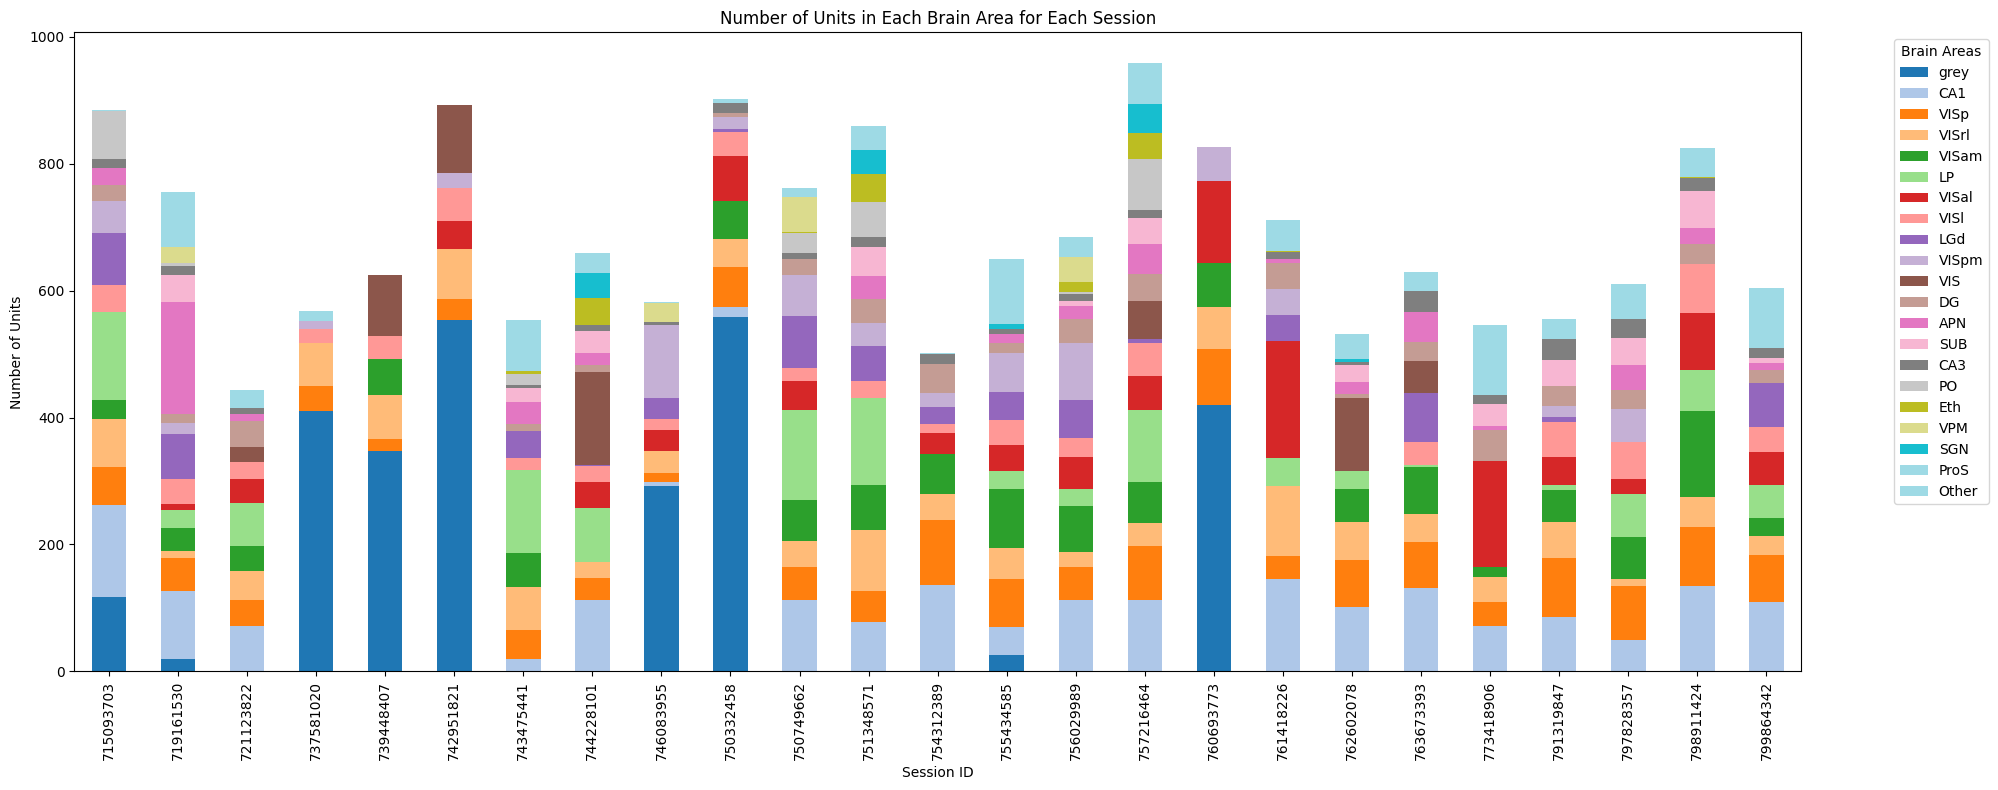

In [84]:
fig, ax = plt.subplots(figsize=(20, 8))

column_order = unit_count_by_area_df.sum(axis=0).sort_values(ascending=False).index.tolist()
unit_count_by_area_df_ordered = unit_count_by_area_df[column_order]

top_areas = unit_count_by_area_df_ordered.columns[:20]  
other_areas = unit_count_by_area_df_ordered.columns[20:]

if len(other_areas) > 0:
    unit_count_by_area_df_ordered["Other"] = unit_count_by_area_df_ordered[other_areas].sum(axis=1)
    unit_count_by_area_df_ordered = unit_count_by_area_df_ordered[top_areas.tolist() + ["Other"]]

unit_count_by_area_df_ordered.plot(kind='bar', stacked=True, ax=ax, colormap='tab20')

ax.set_ylabel('Number of Units')
ax.set_xlabel('Session ID')
ax.set_title('Number of Units in Each Brain Area for Each Session')

plt.xticks(rotation=90)
ax.legend(title='Brain Areas', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()

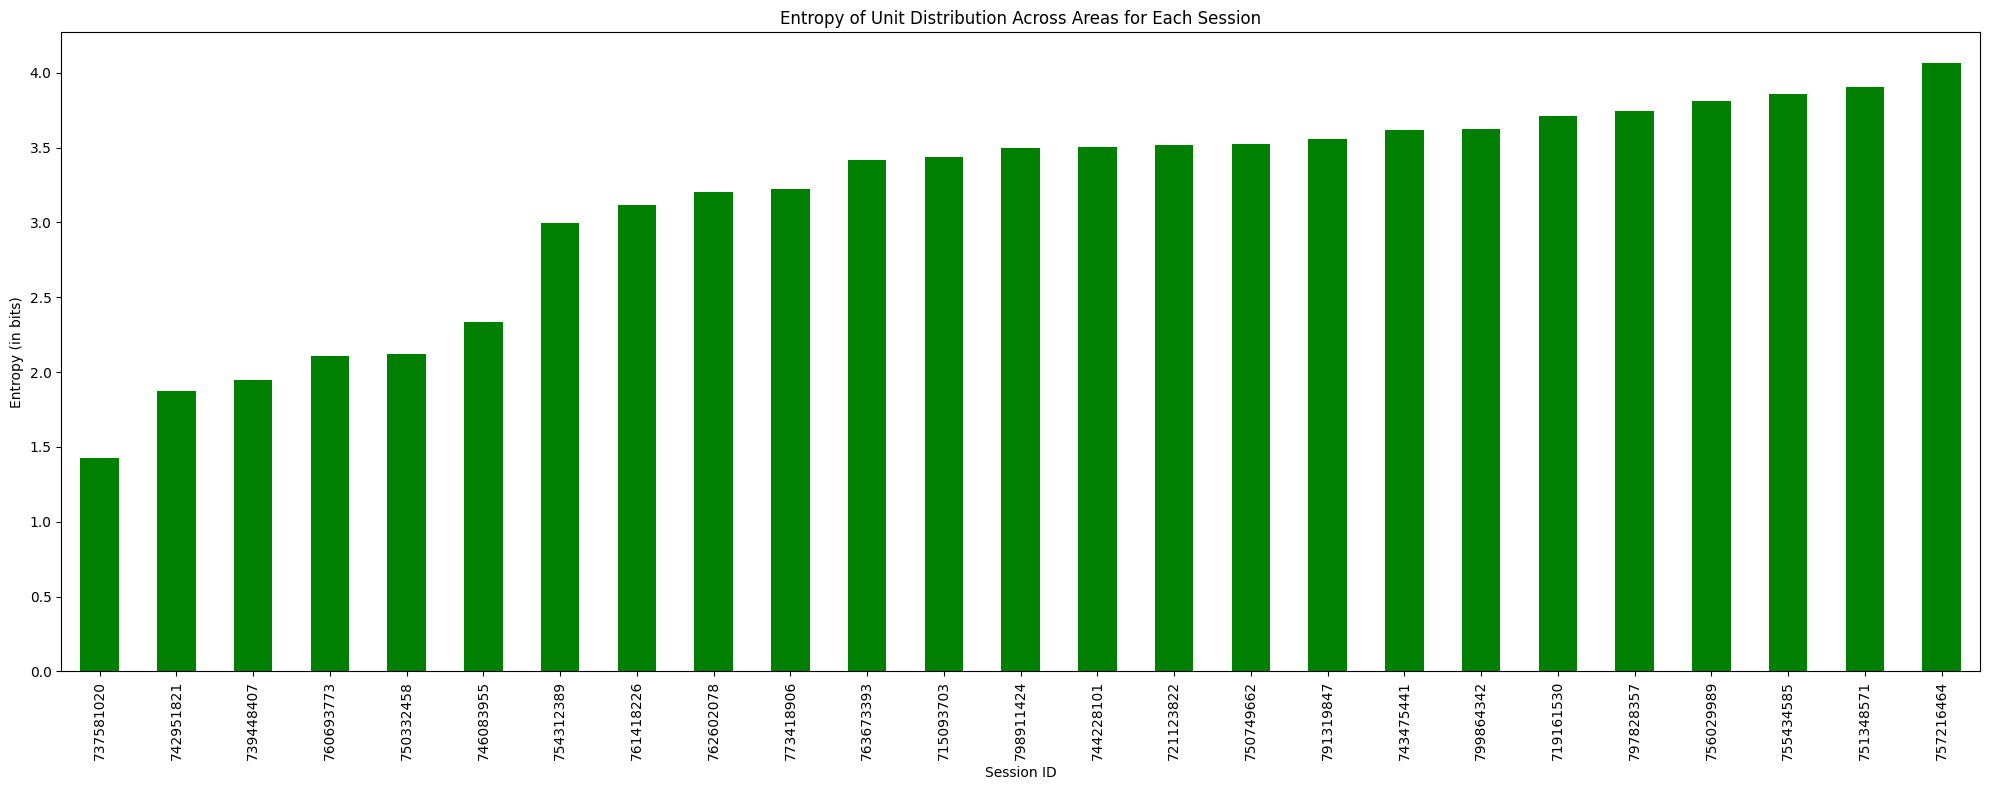

In [85]:
entropy_values = unit_count_by_area_df.apply(compute_entropy, axis=1)

fig, ax = plt.subplots(figsize=(20, 8))

entropy_values = entropy_values.sort_values()

entropy_values.plot(kind='bar', ax=ax, color='green')

ax.set_ylabel('Entropy (in bits)')
ax.set_xlabel('Session ID')
ax.set_title('Entropy of Unit Distribution Across Areas for Each Session')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

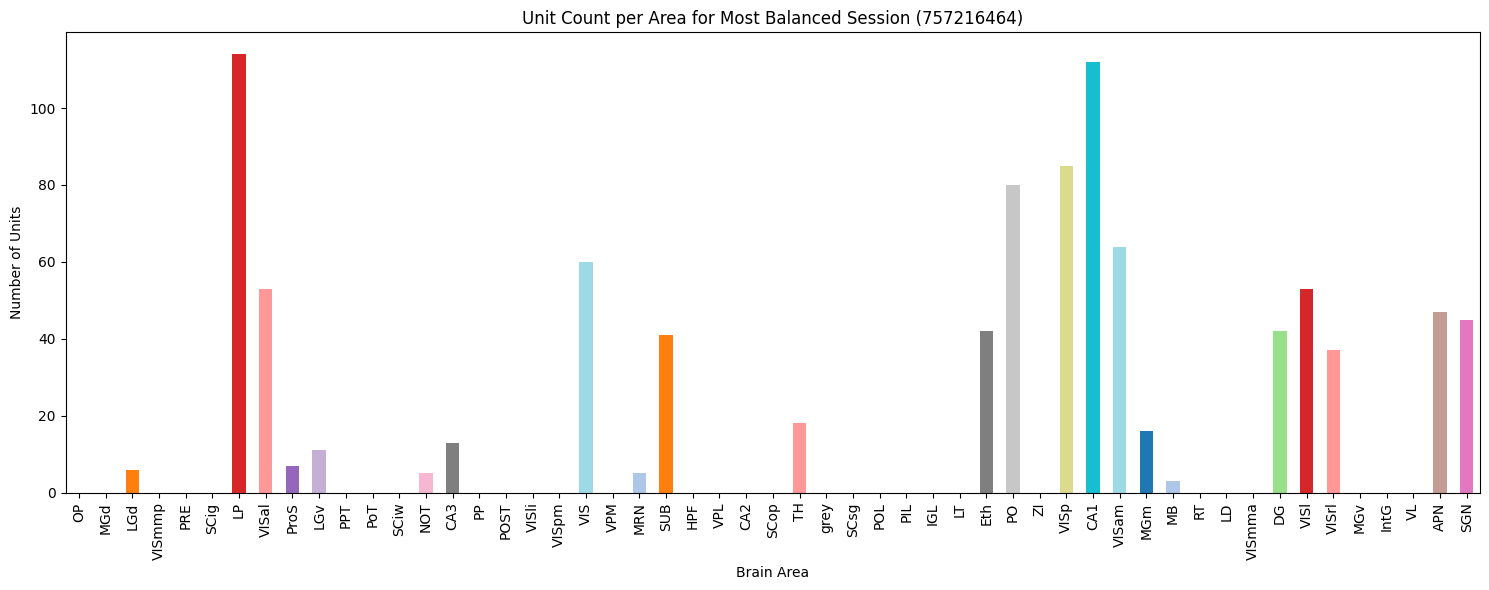

In [86]:
most_balanced_session_entropy = entropy_values.idxmax()
most_balanced_session_value_entropy = entropy_values.max()

session_data = unit_count_by_area_df.loc[most_balanced_session_entropy]

colors = plt.cm.tab20.colors[:len(session_data)]

fig, ax = plt.subplots(figsize=(15, 6))
session_data.plot(kind='bar', ax=ax, color=colors, legend=False)

ax.set_ylabel('Number of Units')
ax.set_xlabel('Brain Area')
ax.set_title(f'Unit Count per Area for Most Balanced Session ({most_balanced_session_entropy})')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()

plt.show()

In [87]:
most_balanced_session = entropy_values.idxmax()
highest_entropy_value = entropy_values.max()

print(f"The most balanced session is {most_balanced_session} with an entropy of {highest_entropy_value:.4f}")

The most balanced session is 757216464 with an entropy of 4.0666


## Data Loading

We initialize a cache from the previously defined function in the data directory of our repo.

From the column above "id" we select the most balanced session_id as seen before, from which we get the session data.

In [89]:
session_id = 757216464
session = get_session_data_from_sessionid(session_id, cache)

Downloading: 100%|██████████| 3.04G/3.04G [03:41<00:00, 13.7MB/s] 


In [90]:
units = cache.get_units()
units

,waveform_PT_ratio,waveform_amplitude,amplitude_cutoff,cumulative_drift,d_prime,waveform_duration,ecephys_channel_id,firing_rate,waveform_halfwidth,isi_violations,...,phase,sampling_rate,has_lfp_data,date_of_acquisition,published_at,specimen_id,session_type,age_in_days,sex,genotype
id,,,,,,,,,,,,,,,,,,,,,
915956282,0.611816,164.878740,0.072728,309.71,3.910873,0.535678,850229419,6.519432,0.164824,0.104910,...,3a,29999.915391,True,2019-01-09T00:26:20Z,2019-10-03T00:00:00Z,717038288,brain_observatory_1.1,100.0,M,wt/wt
915956340,0.439372,247.254345,0.000881,160.24,5.519024,0.563149,850229419,9.660554,0.206030,0.006825,...,3a,29999.915391,True,2019-01-09T00:26:20Z,2019-10-03T00:00:00Z,717038288,brain_observatory_1.1,100.0,M,wt/wt
915956345,0.500520,251.275830,0.001703,129.36,3.559911,0.521943,850229419,12.698430,0.192295,0.044936,...,3a,29999.915391,True,2019-01-09T00:26:20Z,2019-10-03T00:00:00Z,717038288,brain_observatory_1.1,100.0,M,wt/wt
915956349,0.424620,177.115380,0.096378,169.29,2.973959,0.508208,850229419,16.192413,0.192295,0.120715,...,3a,29999.915391,True,2019-01-09T00:26:20Z,2019-10-03T00:00:00Z,717038288,brain_observatory_1.1,100.0,M,wt/wt
915956356,0.512847,214.954545,0.054706,263.01,2.936851,0.549414,850229419,2.193113,0.233501,0.430427,...,3a,29999.915391,True,2019-01-09T00:26:20Z,2019-10-03T00:00:00Z,717038288,brain_observatory_1.1,100.0,M,wt/wt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951911942,0.368040,189.249060,0.001083,122.82,5.362617,0.631826,850103120,0.984659,0.192295,0.080230,...,3a,29999.958001,True,2018-10-31T17:39:23Z,2019-10-03T00:00:00Z,735109609,brain_observatory_1.1,102.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt
951911948,0.660350,80.706600,0.000416,108.17,3.507884,0.302178,850103122,10.327972,0.233501,0.000365,...,3a,29999.958001,True,2018-10-31T17:39:23Z,2019-10-03T00:00:00Z,735109609,brain_observatory_1.1,102.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt
951911955,0.357672,117.232440,0.023316,336.04,2.790057,0.714238,850103126,1.782535,0.192295,0.318256,...,3a,29999.958001,True,2018-10-31T17:39:23Z,2019-10-03T00:00:00Z,735109609,brain_observatory_1.1,102.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt


In [91]:
session.units.head()

,waveform_PT_ratio,waveform_amplitude,amplitude_cutoff,cluster_id,cumulative_drift,d_prime,firing_rate,isi_violations,isolation_distance,L_ratio,...,ecephys_structure_id,ecephys_structure_acronym,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate,probe_description,location,probe_sampling_rate,probe_lfp_sampling_rate,probe_has_lfp_data
unit_id,,,,,,,,,,,,,,,,,,,,,
951812724,0.530584,165.705150,0.064669,0,237.67,6.884674,9.194248,0.016578,99.937016,0.000019,...,128.0,MRN,8292.0,3663.0,6645.0,probeA,See electrode locations,29999.95775,1249.99824,True
951812745,0.442866,190.595730,0.000315,2,261.61,5.568195,8.493725,0.095506,65.697146,0.002596,...,128.0,MRN,8285.0,3638.0,6650.0,probeA,See electrode locations,29999.95775,1249.99824,True
951812785,0.361222,134.263155,0.000120,6,206.92,5.579259,24.437194,0.000587,86.525032,0.008332,...,128.0,MRN,8274.0,3604.0,6655.0,probeA,See electrode locations,29999.95775,1249.99824,True
951812765,0.760445,124.347795,0.002866,4,331.84,5.722753,2.015055,0.019174,65.450579,0.000766,...,128.0,MRN,8277.0,3612.0,6654.0,probeA,See electrode locations,29999.95775,1249.99824,True
951812811,0.563871,89.634870,0.002207,9,169.08,5.157968,37.454772,0.005522,507.037686,0.005300,...,128.0,MRN,8259.0,3552.0,6663.0,probeA,See electrode locations,29999.95775,1249.99824,True


In [92]:
session.metadata.keys()

dict_keys(['specimen_name', 'session_type', 'full_genotype', 'sex', 'age_in_days', 'rig_equipment_name', 'num_units', 'num_channels', 'num_probes', 'num_stimulus_presentations', 'session_start_time', 'ecephys_session_id', 'structure_acronyms', 'stimulus_names'])

In [93]:
session.metadata['stimulus_names']

['spontaneous',
 'gabors',
 'flashes',
 'drifting_gratings',
 'natural_movie_three',
 'natural_movie_one',
 'static_gratings',
 'natural_scenes']

In [94]:
drifting_stimuli = session.get_stimulus_table('drifting_gratings')
drifting_stimuli.head()

,stimulus_block,start_time,stop_time,orientation,spatial_frequency,phase,stimulus_name,size,temporal_frequency,contrast,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,
3798,2.0,1586.113585,1588.115245,90.0,0.04,"[42471.86666667, 42471.86666667]",drifting_gratings,"[250.0, 250.0]",1.0,0.8,2.00166,246
3799,2.0,1589.116095,1591.117775,0.0,0.04,"[42471.86666667, 42471.86666667]",drifting_gratings,"[250.0, 250.0]",8.0,0.8,2.00168,247
3800,2.0,1592.118605,1594.120275,90.0,0.04,"[42471.86666667, 42471.86666667]",drifting_gratings,"[250.0, 250.0]",8.0,0.8,2.00167,248
3801,2.0,1595.121125,1597.122785,135.0,0.04,"[42471.86666667, 42471.86666667]",drifting_gratings,"[250.0, 250.0]",15.0,0.8,2.00166,249
3802,2.0,1598.123625,1600.125295,315.0,0.04,"[42471.86666667, 42471.86666667]",drifting_gratings,"[250.0, 250.0]",1.0,0.8,2.00167,250


In [95]:
static_stimuli = session.get_stimulus_table('static_gratings')
static_stimuli.head()

,stimulus_block,start_time,stop_time,orientation,spatial_frequency,phase,stimulus_name,size,contrast,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,
49434,8.0,5399.300205,5399.550405,0.0,0.32,0.5,static_gratings,"[250.0, 250.0]",0.8,0.250200,4787
49435,8.0,5399.550405,5399.800605,0.0,0.32,0.0,static_gratings,"[250.0, 250.0]",0.8,0.250200,4788
49436,8.0,5399.800605,5400.050805,90.0,0.04,0.5,static_gratings,"[250.0, 250.0]",0.8,0.250200,4789
49437,8.0,5400.050805,5400.301005,120.0,0.16,0.5,static_gratings,"[250.0, 250.0]",0.8,0.250200,4790
49438,8.0,5400.301005,5400.551212,90.0,0.08,0.25,static_gratings,"[250.0, 250.0]",0.8,0.250207,4791


In [102]:
drifting_dataset = stimulus_spike_table(drifting_stimuli, ['stimulus_name', 'temporal_frequency', 'orientation'], session, units)
static_dataset = stimulus_spike_table(static_stimuli, ['stimulus_name', 'spatial_frequency', 'orientation'], session, units)

Stimuli IDs: Int64Index([ 3798,  3799,  3800,  3801,  3802,  3803,  3804,  3805,  3806,
             3807,
            ...
            49423, 49424, 49425, 49426, 49427, 49428, 49429, 49430, 49431,
            49432],
           dtype='int64', name='stimulus_presentation_id', length=630)
Stimuli IDs: Int64Index([49434, 49435, 49436, 49437, 49438, 49439, 49440, 49441, 49442,
            49443,
            ...
            70380, 70381, 70382, 70383, 70384, 70385, 70386, 70387, 70388,
            70389],
           dtype='int64', name='stimulus_presentation_id', length=6000)


In [103]:
drifting_dataset_clean = replace_not_recognized_nulls(drifting_dataset, drop_nan=True)
static_dataset_clean = replace_not_recognized_nulls(static_dataset, drop_nan=True)

Replacing 47930 unrecognized values with np.nan.
Dropped rows containing NaN values.
Replacing 201592 unrecognized values with np.nan.
Dropped rows containing NaN values.


In [104]:
drifting_dataset_clean.head()

,stimulus_presentation_id,unit_id,stimulus_name,temporal_frequency,orientation,spikes_per_second,area
0,3798,951797083,drifting_gratings,1.0,90.0,30.474706,MGm
1,3798,951797141,drifting_gratings,1.0,90.0,2.997512,MGm
2,3798,951797185,drifting_gratings,1.0,90.0,20.482999,MGm
3,3798,951797219,drifting_gratings,1.0,90.0,0.499585,MGm
4,3798,951797253,drifting_gratings,1.0,90.0,4.995853,MGm


In [105]:
static_dataset_clean.head()

,stimulus_presentation_id,unit_id,stimulus_name,spatial_frequency,orientation,spikes_per_second,area
0,49434,951797083,static_gratings,0.32,0.0,43.964810,MGm
1,49434,951797141,static_gratings,0.32,0.0,43.964810,MGm
2,49434,951797185,static_gratings,0.32,0.0,19.984004,MGm
3,49434,951797253,static_gratings,0.32,0.0,23.980805,MGm
4,49434,951797285,static_gratings,0.32,0.0,7.993602,MGm


In [109]:
drifting_dataset_clean.to_parquet(f'ourdata/drifting_dataset_session_{session_id}.parquet')
static_dataset_clean.to_parquet(f'ourdata/static_dataset_session_{session_id}.parquet')